# Question 1

Use Sklearn Library to train Decision Tress. [1.5 marks]

1. Train a decision tree model using the raw accelerometer data. Report the accuracy, precision, recall and confusion matrix of the model.
2. Train a decision tree model using the features obtained by TSFEL. Report the accuracy, precision, recall and confusion matrix of the model.
3. Train a decision tree model using the features provided in the dataset. Report the accuracy, precision, recall and confusion matrix of the model.
4. Compare the results of the three models. Which model do you think is better?


In [320]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
import tsfel
import matplotlib.pyplot as plt

### Modal 1: Using raw accelerometer data


In [321]:
# make the data directory path
raw_data_dir = os.path.join("../HAR/UCI HAR Dataset")

# make the train and test directories paths
train_dir = os.path.join(raw_data_dir, "train")
test_dir = os.path.join(raw_data_dir, "test")

# load all the train accelerometer data
total_acc_x = pd.read_csv(os.path.join(train_dir,"Inertial Signals","total_acc_x_train.txt"),delim_whitespace=True,header=None)
total_acc_y = pd.read_csv(os.path.join(train_dir,"Inertial Signals","total_acc_y_train.txt"),delim_whitespace=True,header=None)
total_acc_z = pd.read_csv(os.path.join(train_dir,"Inertial Signals","total_acc_z_train.txt"),delim_whitespace=True,header=None)

X_train_files = [total_acc_x, total_acc_y, total_acc_z]

# concatenate the data
X_train_raw = pd.concat(X_train_files, axis=1) # (7352, (128 * 3 =) 384)

# load the labels
y_train_raw = pd.read_csv(os.path.join(train_dir, "y_train.txt"), header=None)

# load all the test accelerometer data
total_acc_x = pd.read_csv(os.path.join(test_dir,"Inertial Signals","total_acc_x_test.txt"),delim_whitespace=True,header=None)
total_acc_y = pd.read_csv(os.path.join(test_dir,"Inertial Signals","total_acc_y_test.txt"),delim_whitespace=True,header=None)
total_acc_z = pd.read_csv(os.path.join(test_dir,"Inertial Signals","total_acc_z_test.txt"),delim_whitespace=True,header=None)

X_test_files = [total_acc_x, total_acc_y, total_acc_z]

# concatenate the data
X_test_raw = pd.concat(X_test_files, axis=1) # (2947, (128 * 3 =) 384)

# load the labels
y_test_raw = pd.read_csv(os.path.join(test_dir, "y_test.txt"), header=None)

/var/folders/zs/jphm90712636hwjl914hl1v80000gn/T/ipykernel_84377/2564848619.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  total_acc_x = pd.read_csv(os.path.join(train_dir,"Inertial Signals","total_acc_x_train.txt"),delim_whitespace=True,header=None)
/var/folders/zs/jphm90712636hwjl914hl1v80000gn/T/ipykernel_84377/2564848619.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  total_acc_y = pd.read_csv(os.path.join(train_dir,"Inertial Signals","total_acc_y_train.txt"),delim_whitespace=True,header=None)
/var/folders/zs/jphm90712636hwjl914hl1v80000gn/T/ipykernel_84377/2564848619.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  total_acc_z = pd.read_csv(os.path.join(train_dir,"Inertial Signa

In [322]:
# No need to reshape the data since it is already in the correct format i.e. features as columns and samples as rows

# set up the decision tree classifier
dtc_raw = DecisionTreeClassifier()
dtc_raw.fit(X_train_raw, y_train_raw)

# predict
y_pred_raw = dtc_raw.predict(X_test_raw)

# judge the model using the accuracy, precision, recall, and confusion matrix
acc_raw = accuracy_score(y_test_raw, y_pred_raw)

# since, our raw dataset is imbalanced, we will use weighted average for precision and recall
# imbalanced means different classes have different number of samples
prec_raw = precision_score(y_test_raw, y_pred_raw, average="weighted")
rec_raw = recall_score(y_test_raw, y_pred_raw, average="weighted")
conf_mx_raw = confusion_matrix(y_test_raw, y_pred_raw)

print("Raw data accuracy: ", acc_raw)
print("Raw data precision: ", prec_raw)
print("Raw data recall: ", rec_raw)
print()
print("Raw data confusion matrix:")
print(conf_mx_raw)

Raw data accuracy:  0.7098744485917883
Raw data precision:  0.711469244347793
Raw data recall:  0.7098744485917883

Raw data confusion matrix:
[[288  94  95  11   8   0]
 [106 304  49   2  10   0]
 [105  64 243   6   2   0]
 [  2  24   4 356 105   0]
 [  9  15   1 143 364   0]
 [  0   0   0   0   0 537]]


#### Creating the processed dataset for Models 2 and 3


In [323]:
time = 10 # Setting the time window for each sample
offset = 100 # Skipping the first 100 rows to remove noise
folders = ["LAYING","SITTING","STANDING","WALKING","WALKING_DOWNSTAIRS","WALKING_UPSTAIRS"]
classes = {"WALKING":1,"WALKING_UPSTAIRS":2,"WALKING_DOWNSTAIRS":3,"SITTING":4,"STANDING":5,"LAYING":6}

combined_dir = os.path.join("../Combined")

X_train=[]
y_train=[]
dataset_dir = os.path.join(combined_dir,"Train")

for folder in folders:
    files = os.listdir(os.path.join(dataset_dir,folder))

    for file in files:

        df = pd.read_csv(os.path.join(dataset_dir,folder,file),sep=",",header=0)
        df = df[offset:offset+time*50]
        X_train.append(df.values)
        y_train.append(classes[folder])

X_train = np.array(X_train)
y_train = np.array(y_train)

X_test=[]
y_test=[]
dataset_dir = os.path.join(combined_dir,"Test")

for folder in folders:
    files = os.listdir(os.path.join(dataset_dir,folder))
    for file in files:

        df = pd.read_csv(os.path.join(dataset_dir,folder,file),sep=",",header=0)
        df = df[offset:offset+time*50]
        X_test.append(df.values)
        y_test.append(classes[folder])

X_test = np.array(X_test)
y_test = np.array(y_test)

# USE THE BELOW GIVEN DATA FOR TRAINING and TESTING purposes

# concatenate the training and testing data
X = np.concatenate((X_train,X_test))
y = np.concatenate((y_train,y_test))

# split the data into training and testing sets. Change the seed value to obtain different random splits.
seed = 4
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=seed,stratify=y)

print("Training data shape: ", X_train.shape) # (number of samples, number of time steps (x (=10) sec * 50Hz), number of features)
print("Testing data shape: ", X_test.shape)
print("Training labels shape: ", y_train.shape)
print("Testing labels shape: ", y_test.shape)

# Data - 3D array of 180 samples
# Splitting 180 samples into 70% training and 30% testing data so 126 samples for training and 54 samples for testing
# 126 / 6 = 21 meaning 21 samples per activity
# 500 = 10 * 50 meaning 500 time steps per sample as 10 seconds of data is collected at 50Hz
# 3 signifies the number of features (x, y, z) for each time step

# Labels - 1D array of 180 labels
# 126 means 126 labels for the training data according to the corresponding activity
# 54 means 54 labels for the testing data according to the corresponding activity

Training data shape:  (126, 500, 3)
Testing data shape:  (54, 500, 3)
Training labels shape:  (126,)
Testing labels shape:  (54,)


### Modal 2: Using features obtained by TSFEL


##### Just for the sake of understanding:

TSFEL - Time Series Feature Extraction Library is a Python package specifically designed to automate the process of extracting meaningful features from time series data.

It's main advantages are:

1. Extracting meaningful and relevant features using pre-defined feature extraction functions.
2. Wide variety of features that help in exploring different characteristics.
3. Helps in discovering hidden patterns or relationships that might not be apparent from the raw readings alone.
4. By providing a broader set of potentially informative features, TSFEL can help machine learning models achieve better performance compared to using only the raw data.


In [324]:
# the TSFEL library expects the data in pandas dataframe format where each column represents a time series and each row represents a time step
X_train_dfs = []

for sample in X_train:
  df = pd.DataFrame(sample, columns=['accx', 'accy', 'accz'])
  X_train_dfs.append(df)

X_test_dfs = []

for sample in X_test:
  df = pd.DataFrame(sample, columns=['accx', 'accy', 'accz'])
  X_test_dfs.append(df)

# we will be using the default tsfel configuration for the features
# this is a dictionary that specifies a wide range of features to be extracted across different domains (statistical, temporal, spectral, etc.).
tsfel_config = tsfel.get_features_by_domain()
# print(len(tsfel_config["spectral"]) + len(tsfel_config["fractal"]) + len(tsfel_config["statistical"]) + len(tsfel_config["temporal"]))
# ? This gives 67

# extract features for X_train
# iterating over each sample to characterize its unique features
# if we combine all our samples into a single dataframe and then extract features, TSFEL might interpret the entire concatenated time series as a single entity. This could lead to features being calculated across different activities, which might not be meaningful or useful for our classification task.
# since our accelerometer data is sampled at 50Hz, we need to tell TSFEL that the sampling frequency is 50Hz so that when it calculates features that depend on time, it can use the correct time intervals.
# TSFEL uses FFT to calculate the spectral features and hence requires the sampling frequency to be the same as the actual sampling frequency of the data.
# we haven't mentioned overlap and window_size as the data which we are using is already windowed and has no overlap.
# according to the TSFEL documentation, if we have access to the actual sampling frequency, we should provide it to the library as a good practice.
X_train_tsfel_dfs = []
for df in X_train_dfs:
    feature_df = tsfel.time_series_features_extractor(tsfel_config, df, fs=50)
    X_train_tsfel_dfs.append(feature_df)
# the output of tsfel.time_series_features_extractor(tsfel_config, df, fs=50) is a pandas dataframe containing the extracted features where each row represents a sample and each column represents a feature as specified in the tsfel_config dictionary.
# ? Here each dataframe is of size 1 x (3 * 384) = 1 x 1152

# convert the list of feature dataframe back to a numpy array
# since we have 126 samples and each sample has 1152 features, the shape of the array should be (126, 1152)
# there are some NaN values because some features are not applicable to the data and hence are not calculated
# fill NaN values with 0 to ensure the array is compatible with scikit-learn
X_train_tsfel = pd.concat(X_train_tsfel_dfs, axis=0).fillna(0).values

# Same for X_test
X_test_tsfel_dfs = []
for df in X_test_dfs:
    feature_df = tsfel.time_series_features_extractor(tsfel_config, df, fs=50)
    X_test_tsfel_dfs.append(feature_df)
# Since we have 54 samples and each sample has 1152 features, the shape of the array should be (54, 1152)
X_test_tsfel = pd.concat(X_test_tsfel_dfs, axis=0).fillna(0).values

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


In [325]:
dtc_tsfel = DecisionTreeClassifier()
dtc_tsfel.fit(X_train_tsfel, y_train)
y_pred_tsfel = dtc_tsfel.predict(X_test_tsfel)
acc_tsfel = accuracy_score(y_test, y_pred_tsfel)

# Since, this model is using the provided dataset which is balanced, we will use macro average for precision and recall
prec_tsfel = precision_score(y_test, y_pred_tsfel, average='macro')
rec_tsfel = recall_score(y_test, y_pred_tsfel, average='macro')

conf_mx_tsfel = confusion_matrix(y_test, y_pred_tsfel)

print("TSFEL Accuracy:", acc_tsfel)
print("TSFEL Precision:", prec_tsfel)
print("TSFEL Recall:", rec_tsfel)
print()
print("TSFEL Confusion Matrix:")
print(conf_mx_tsfel)

TSFEL Accuracy: 0.8888888888888888
TSFEL Precision: 0.8977272727272728
TSFEL Recall: 0.8888888888888888

TSFEL Confusion Matrix:
[[9 0 0 0 0 0]
 [1 7 1 0 0 0]
 [1 1 7 0 0 0]
 [0 0 0 7 2 0]
 [0 0 0 0 9 0]
 [0 0 0 0 0 9]]


#### Model 3: Using processed dataset


The decision tree classifier expects the input features to be in a 2D array format where row represents an instance of the data \(meaning acitivity for us\) and each column represents a feature \(meaning x, y, z axis acceleration for us\).

Currently the format of our data is a 3 dimensional data where each sample is itself a 2D array representing the time steps of the x, y, z axis accelerometer readings.

The decision tree classifer needs a 2D array, where each sample is represented as a single row with all its features flattened out.

So, we need to flatten the shape of training and test data from (126, 500, 3) to \(126, 500 \* 3 = 1500\)


In [326]:
# reshaping the training and tes data to fit the decision tree classifier as discussed above
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
dtc_dataset = DecisionTreeClassifier()
dtc_dataset.fit(X_train_reshaped, y_train)
y_pred_dataset = dtc_dataset.predict(X_test_reshaped)
acc_dataset = accuracy_score(y_test, y_pred_dataset)

# Since, this model is using the provided dataset which is balanced, we will use macro average for precision and rec_dataset
prec_dataset = precision_score(y_test, y_pred_dataset, average='macro')
rec_dataset = recall_score(y_test, y_pred_dataset, average='macro')

conf_mx_dataset = confusion_matrix(y_test, y_pred_dataset)

# Print the results
print("Provided Dataset Accuracy:", acc_dataset)
print("Provided Dataset Precision:", prec_dataset)
print("Provided Dataset Recall:", rec_dataset)
print()
print("Provided Dataset Confusion Matrix:")
print(conf_mx_dataset)

Provided Dataset Accuracy: 0.6666666666666666
Provided Dataset Precision: 0.673611111111111
Provided Dataset Recall: 0.6666666666666666

Provided Dataset Confusion Matrix:
[[3 2 2 0 2 0]
 [0 5 2 2 0 0]
 [1 1 3 3 1 0]
 [0 0 0 8 1 0]
 [0 0 0 1 8 0]
 [0 0 0 0 0 9]]


# Question 2

Train Decision Tree with varying depths (2-8) using all above 3 methods. Plot the accuracy of the model on test data vs the depth of the tree. [1 marks]


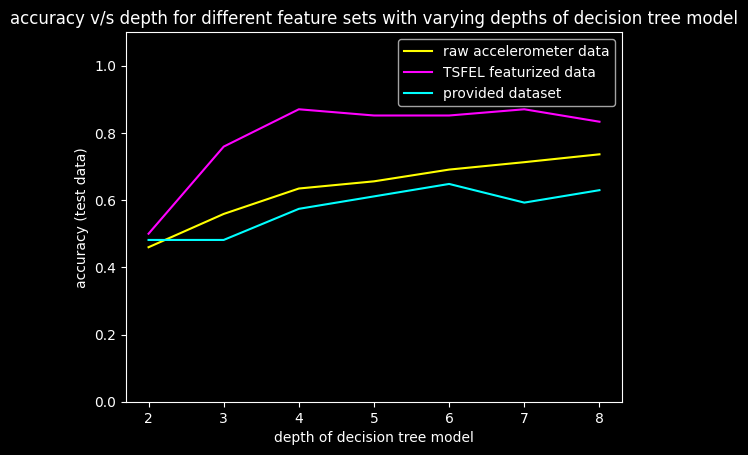

In [327]:
# define lists to store accuracy scores for all three feature sets
acc_scores_raw = []
acc_scores_tsfel = []
acc_scores_dataset = []

depths = range(2, 9)

# raw accelerometer data
for depth in depths:
    dtf_raw = DecisionTreeClassifier(max_depth=depth)
    dtf_raw.fit(X_train_raw, y_train_raw)
    y_pred_raw = dtf_raw.predict(X_test_raw)
    acc_raw = accuracy_score(y_test_raw, y_pred_raw)
    acc_scores_raw.append(acc_raw)

# TSFEL
for depth in depths:
    dtf_tsfel = DecisionTreeClassifier(max_depth=depth)
    dtf_tsfel.fit(X_train_tsfel, y_train)
    y_pred_tsfel = dtf_tsfel.predict(X_test_tsfel)
    acc_tsfel = accuracy_score(y_test, y_pred_tsfel)
    acc_scores_tsfel.append(acc_tsfel)

# provided dataset
for depth in depths:
    dtf_dataset = DecisionTreeClassifier(max_depth=depth)
    dtf_dataset.fit(X_train_reshaped, y_train)
    y_pred_dataset = dtf_dataset.predict(X_test_reshaped)
    acc_dataset = accuracy_score(y_test, y_pred_dataset)
    acc_scores_dataset.append(acc_dataset)

# plot the accuracy scores
plt.plot(depths, acc_scores_raw, label='raw accelerometer data', color="yellow")
plt.plot(depths, acc_scores_tsfel, label='TSFEL featurized data', color="magenta")
plt.plot(depths, acc_scores_dataset, label='provided dataset', color="cyan")
plt.xlabel('depth of decision tree model')
plt.ylabel('accuracy (test data)')
plt.ylim(0, 1.1)
plt.title('accuracy v/s depth for different feature sets with varying depths of decision tree model')
plt.legend()
plt.show()

From this, we can see that the TSFEL model performs far better than tha other two models. This is mainly due to the fact that TSFEL extracts meaningful and relevant information about each sample which effectively highlight patterns that are not immediately apparent from raw time series data. TSFEL also reduces noise and redundant, irrelevant information that may hide the patterns the model needs to learn. Moreover, spectral features can reveal repetiation and oscillations in the data that might indicate specific activities.


# Question 3

Are there any participants/ activitivies where the Model performace is bad? If Yes, Why? [0.5 mark]


First, let's check for activities.


We will use the TSFEL model with depth = 8 to see if there are any participants / activities where the model is performing poorly.

A low precision means many false positives.

A low recall means many false negatives.

Precision is low for a certain activity, it means the model frequently misclassifies other activities as this one.

Recall is low for a certain activity, it means the model misses many instances of this activity.

F1 score is the harmonic mean of precision and recall so it would be a good factor to judge the model for each activity.


In [328]:
activities = {1: "WALKING", 2: "WALKING UPSTAIRS", 3: "WALKING DOWNSTAIRS", 4: "SITTING", 5: "STANDING", 6: "LAYING"}

# set average=None to get precision, recall, and F1 score for each class
prec_per_act = precision_score(y_test, y_pred_tsfel, average=None, labels=list(activities.keys()))
rec_per_act = recall_score(y_test, y_pred_tsfel, average=None, labels=list(activities.keys()))
f1_per_act = f1_score(y_test, y_pred_tsfel, average=None, labels=list(activities.keys()))

for i, (prec, rec, f1) in enumerate(zip(prec_per_act, rec_per_act, f1_per_act)):
    act_name = activities.get(i + 1)
    print(act_name)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1 score:", f1)
    print()

WALKING
Precision: 0.75
Recall: 1.0
F1 score: 0.8571428571428571

WALKING UPSTAIRS
Precision: 0.7142857142857143
Recall: 0.5555555555555556
F1 score: 0.625

WALKING DOWNSTAIRS
Precision: 0.75
Recall: 0.6666666666666666
F1 score: 0.7058823529411765

SITTING
Precision: 1.0
Recall: 0.7777777777777778
F1 score: 0.875

STANDING
Precision: 0.8181818181818182
Recall: 1.0
F1 score: 0.9

LAYING
Precision: 1.0
Recall: 1.0
F1 score: 1.0



From this, we can see that the activity "Walking Upstairs" and "Walking Downstairs" have the worst f1 score.


Now, let's check for participants.


We will need the original unsplitted X_train, X_test, y_train, y_test so we'll need to contruct these data again.

To retain the participant numbers, we will store them as well along with training data and test data.

Now, when we split the data, we will split all (X_train, X_test, y_train, y_test, p_number_train, p_number_test) data together which will make the participant numbers still intact (in correct order...)


In [329]:
activities = {"WALKING": 1, "WALKING_UPSTAIRS": 2, "WALKING_DOWNSTAIRS": 3, "SITTING": 4, "STANDING": 5, "LAYING": 6}

X_train=[]
y_train=[]
p_number_train = [] # participant number for training data

for folder in folders:
    files = os.listdir(os.path.join(dataset_dir,folder))
    for file in files:
        df = pd.read_csv(os.path.join(dataset_dir,folder,file),sep=",",header=0)
        df = df[offset:offset+time*50]
        X_train.append(df.values)
        y_train.append(activities[folder])
        # getting the participant number from the file name which is the part between _ and .
        p_number_train.append(int(file.split("_")[1].split(".")[0]))

X_train = np.array(X_train)
y_train = np.array(y_train)
p_number_train = np.array(p_number_train)

X_test=[]
y_test=[]
p_number_test = [] # participant number for testing data

for folder in folders:
    files = os.listdir(os.path.join(dataset_dir,folder))
    for file in files:
        df = pd.read_csv(os.path.join(dataset_dir,folder,file),sep=",",header=0)
        df = df[offset:offset+time*50]
        X_test.append(df.values)
        y_test.append(activities[folder])
        p_number_test.append(int(file.split("_")[1].split(".")[0]))

X_test = np.array(X_test)
y_test = np.array(y_test)
p_number_test = np.array(p_number_test)

# Combine training and testing data
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))
p_number = np.concatenate((p_number_train, p_number_test))

# split the data, including participant numbers as well
X_train,X_test,y_train,y_test, p_number_train, p_number_test = train_test_split(X,y,p_number,test_size=0.3,stratify=y,random_state=seed)

In [335]:
p_f1 = {} # dictionary to store F1 scores for each participant

unique_p = np.unique(p_number_test)

# calculate F1 score for each participant
for p_id in unique_p:
    # get the indexes for the current participant from the test data
    p_ind = np.where(p_number_test == p_id)
    # print(p_ind)
    y_test_p = y_test[p_ind]
    y_pred_p = y_pred_tsfel[p_ind]
    f1_p = f1_score(y_test_p, y_pred_p, average='weighted')
    p_f1[p_id] = f1_p

# print the scores
for p_id, f1_score_value in p_f1.items():
    print("Participant:", p_id)
    print("F1 score:", f1_score_value)
    print()


Participant: 2
F1 score: 0.0

Participant: 4
F1 score: 0.13333333333333333

Participant: 9
F1 score: 0.125

Participant: 10
F1 score: 0.25

Participant: 12
F1 score: 0.0

Participant: 13
F1 score: 0.25

Participant: 20
F1 score: 0.0

Participant: 24
F1 score: 0.0

